In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

### First we set a seed for deterministic output and ease of reproducability.

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # ensures deterministic algorithms
    torch.backends.cudnn.benchmark = False     # can slow down, but more reproducible

set_seed(42)

### Now we create the RNN and DataSet classes for our weather predictions.

In [3]:
class WeatherRNN(nn.Module):
  def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int=1, rnn_type:str='RNN', dropout:float=0.0):
    super().__init__()

    # potential RNN classes
    rnn_options = {"RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU}

    if rnn_type not in rnn_options:
      raise ValueError(f'rnn_type must be one of {list(rnn_options.keys())}')

    # force dropout to be 0 if num_layers == 1
    dropout = dropout if num_layers > 1 else 0.0

    # define the rnn
    self.rnn = rnn_options[rnn_type](input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    # fully connected linear layers
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h0=None):
    batch_size = x.size(0)
    out, _ = self.rnn(x) if h0 is None else self.rnn(x, h0)
    out = self.fc(out[:,-1,:])
    return out, _

In [4]:
class TimeSeries(Dataset):
  def __init__(self, data, seq_len):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.seq_len = seq_len

  def __len__(self):
    # subtract self.seq_len to account for data where previous sequence is unknown
    return len(self.data) - self.seq_len

  def __getitem__(self, start_idx):
    end_idx = start_idx + self.seq_len

    X_seq = self.data[start_idx:end_idx].unsqueeze(-1) # (seq_len x 1)
    y = self.data[end_idx].unsqueeze(-1) # (1,)

    return X_seq, y

### Now we can load our training data. For now, we will only predict the next day's maximum temperature using the previous week's maximum temperatures.

In [5]:
train_data = pd.read_csv('../Project1/merged_data/denver_weather_train.csv')
train_data["DATE"] = pd.to_datetime(train_data["DATE"])
train_data = train_data[train_data["STATION"]==0]
train_data = train_data[["DATE", "TMAX"]]
train_data.reset_index(inplace=True, drop=True)
train_data.head()

,DATE,TMAX
0,2005-01-01,51.0
1,2005-01-02,34.0
2,2005-01-03,49.0
3,2005-01-04,28.0
4,2005-01-05,7.0


In [6]:
# initialize the dataset and data loader for the training data
train_dataset = TimeSeries(train_data["TMAX"], seq_len=7)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True)

### Now we will set the device and the model's hyperparameters. The we will be training a LSTM model with an input size of 1 (the maximum temperature) and an output size of 1 (the maximum temperature). The size of the hidden state will be set to 16. We will use the MSE as our loss function with the adam optimizer and a learning rate of $\eta=0.001$. We will train the model for 100 epochs.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WeatherRNN(input_size=1, hidden_size=16, output_size=1, num_layers=1, rnn_type="LSTM").to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100

In [8]:
hidden = None
training_loss = []

for epoch in range(epochs):
  total_loss = 0
  hidden = None  # reset hidden each epoch if needed

  for x_batch, y_batch in train_loader:  # loader gives sequential chunks
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    if hidden is not None:
        if isinstance(hidden, tuple):  # for LSTM
            hidden = (hidden[0].detach(), hidden[1].detach())
        else:
            hidden = hidden.detach()

    output, hidden = model(x_batch, hidden)
    loss = criterion(output, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  total_loss /= len(train_loader)
  training_loss.append(total_loss)

  if epoch % 10 == 9:
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 10: Loss = 1764.0951
Epoch 20: Loss = 705.6810
Epoch 30: Loss = 321.9350
Epoch 40: Loss = 171.1877
Epoch 50: Loss = 114.9792
Epoch 60: Loss = 97.7021
Epoch 70: Loss = 93.2274
Epoch 80: Loss = 91.9266
Epoch 90: Loss = 91.4073
Epoch 100: Loss = 91.0209


### Let's visualize how the training loss changes as we train the model.

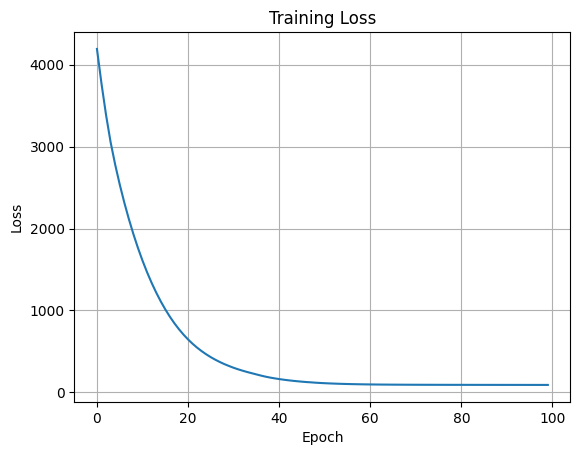

In [9]:
plt.plot(training_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

### Now that the model has finished training, let's see what it's predictions are on the training data.

In [10]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
train_predictions = []

model.eval()

with torch.no_grad():
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        out, _ = model(x_batch)
        train_predictions.append(out.item())     # predicted value

In [11]:
def insert_predictions(df, predictions, prediction_name, seq_len, new_index=None):
    # insert column values
    df[prediction_name] = seq_len*[np.nan] + predictions

    if new_index != None:
        df.set_index(new_index, inplace=True)

    return df

train_data = insert_predictions(train_data, train_predictions, "Predicted", 7, new_index="DATE")
train_data.rename({"TMAX": "True"}, inplace=True)

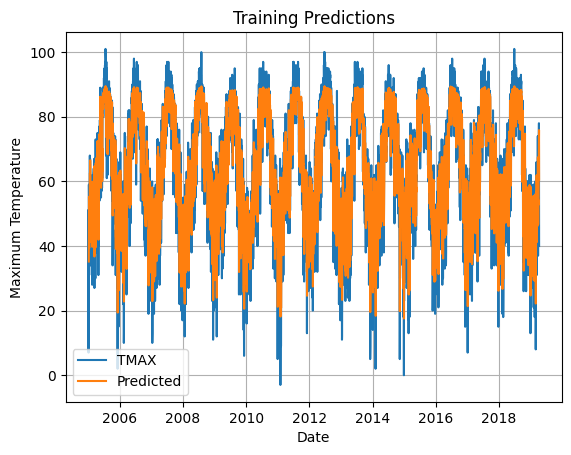

In [12]:
def plot_predictions(df, sample_type):
    fig = plt.figure()
    for col in df.columns:
        plt.plot(df[col], label=col)
    
    plt.title(f"{sample_type} Predictions")
    plt.xlabel("Date")
    plt.ylabel("Maximum Temperature")
    plt.legend()
    plt.grid()
    plt.close()
    return fig

plot_predictions(train_data, "Training")

### Finally, we can test the model to see how well it performs on unseen data. As with the training data, we start by loading it from the csv file.

In [13]:
test_data = pd.read_csv('../Project1/merged_data/denver_weather_test.csv')
test_data["DATE"] = pd.to_datetime(test_data["DATE"])
test_data = test_data[test_data["STATION"]==0]
test_data = test_data[["DATE", "TMAX"]]
test_data.head()

,DATE,TMAX
0,2022-04-03,50.0
4,2022-04-04,65.0
9,2022-04-05,60.0
11,2022-04-06,46.0
14,2022-04-07,50.0


In [14]:
test_dataset = TimeSeries(test_data["TMAX"], seq_len=7)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Now we can test its performance on unseen data.

In [15]:
# test the model on unseen data in the future

test_predictions = []

model.eval()

with torch.no_grad():
  for x_batch, y_batch in test_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    out, _ = model(x_batch)
    test_predictions.append(out.item())     # predicted value
    

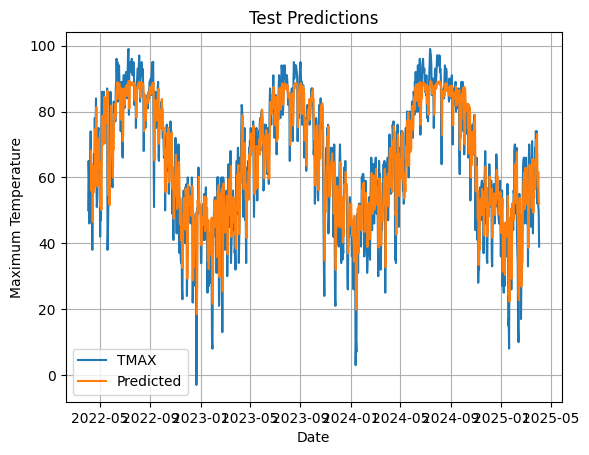

In [16]:
test_data = insert_predictions(test_data, test_predictions, "Predicted", 7, new_index="DATE")
test_data.rename({"TMAX": "True"}, inplace=True)
plot_predictions(test_data, "Test")